In [ ]:
%load_ext nb_black
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [ ]:
from src.data import make_dataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    cross_validate,
    cross_val_score,
    train_test_split,
    PredefinedSplit,
)
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)
from sklearn.compose import ColumnTransformer

# from category_encoders import OrdinalEncoder
from sklearn.feature_selection._base import SelectorMixin
from sklearn.feature_extraction.text import _VectorizerMixin
from sklearn.inspection import permutation_importance
from rfpimp import *
from IPython.display import display, HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

import shap  # package used to calculate Shap values
from tpot import TPOTRegressor

# Model Building

 Scoring Metrics
- R-squared
 - shows the proportional improvement in prediction from the regression model, compared to the mean model.
 - a
 good model can give R-squared score close to 1.0 but it does not mean it should be. 

- MSE (Mean Squared Error)
 - indicates the absolute fit of the model to the data; how close the observed data points are to the model’s predicted values
 - Models which have low R-squared can also give low MSE score. 
 - RMSE has the useful property of being in the same units as the response variable.
 
To ensure the predictive power of the model it is best to use MSE and R-squared.
 
- OOB (Out-of-Bag) score 
 - technically also an R2 score, because it uses the same mathematical formula
 - RF calculates it internally using only the training data
 - both scores predict the generalizability of the model – i.e. its expected performance on new, unseen data
 - can be used if you don’t have enough data to split for train and validation set

## Baseline

In [25]:
# restrict training data to original features only
X_train_orig = X_train[orig_features]
X_test_orig = X_test[orig_features]

# baseline RF model with default hyperparameter settings using training data
rf0 = RandomForestRegressor(random_state=seed, oob_score=True)

# fit the model to the training data without any added features
rf0.fit(X_train_orig, y_train)

# check which hyperparameter settings are used
print(rf0.get_params())

# baseline RF model with default hyperparameter settings using training data
rf1 = RandomForestRegressor(random_state=seed, oob_score=True)

# fit the model to the training data without any added features
rf1.fit(X_train, y_train)

# hold-out method
def fit_and_evaluate_model(model, train_set, test_set):

    print("Number of features used:", model.n_features_)

    # score the model on the train data
    print("R-squared Value (train)   :{:.2f}".format(model.score(train_set, y_train)))
    # score the model on the test data
    print("R-squared Value (test)    :{:.2f}".format(model.score(test_set, y_test)))
    # Out-Of_Bag score
    print("OOB (Out-Of-Bag) value    :{:.2f}".format(model.oob_score_))

    # calculated the mse by comparing predictions against true values
    print(
        "Mean Squared Error (train):{:.2f}".format(
            mean_squared_error(y_train, model.predict(train_set))
        )
    )
    print(
        "Mean Squared Error (test) :{:.2f}".format(
            mean_squared_error(y_test, model.predict(test_set))
        )
    )


print("Model evaluation without any added features:")
fit_and_evaluate_model(rf0, X_train_orig, X_test_orig)

print("Model evaluation including transformed features:")
fit_and_evaluate_model(rf1, X_train, X_test)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': True, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Model evaluation without any added features:
Number of features used: 16
R-squared Value (train)   :0.98
R-squared Value (test)    :0.86
OOB (Out-Of-Bag) value    :0.82
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.13
Model evaluation including transformed features:
Number of features used: 25
R-squared Value (train)   :0.98
R-squared Value (test)    :0.85
OOB (Out-Of-Bag) value    :0.83
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.13


Due to there being a low number of training samples we can see a big variation in the model accuracy when using
random sampling to split our data into training and validation sets.
If we change the random seed or not use one at all then the accuracy score can change siginificantly each time.

K-fold cross-validation or OOB score are more robust evaluation techniques to use for a dataset of this size.

In [26]:
# K-fold cross-validation
rf1 = cross_validate(
    rf0,
    X_train,
    y_train,
    return_train_score=True,
    scoring=("r2", "neg_mean_squared_error"),
    cv=5,
)
print("R-squared values (train)              : {}".format(rf1["train_r2"]))
print("R-squared values mean (train)         : {:.2f}".format(rf1["train_r2"].mean()))
print("R-squared values (test)               : {}".format(rf1["test_r2"]))
print("R-squared values mean (test)          : {:.2f}".format(rf1["test_r2"].mean()))
print(
    "Mean Squared Error values (train)     : {}".format(
        rf1["train_neg_mean_squared_error"]
    )
)
print(
    "Mean Squared Error mean (train)       : {:.2f}".format(
        rf1["train_neg_mean_squared_error"].mean()
    )
)
print(
    "Mean Squared Error values (test)      : {}".format(
        rf1["test_neg_mean_squared_error"]
    )
)
print(
    "Mean Squared Error values mean (test) : {:.2f}".format(
        rf1["test_neg_mean_squared_error"].mean()
    )
)

# due to there being a low number of training samples we can see a big variation in the model accuracy when using
# random sampling to split our data into training and validation sets
# If we change the random seed or not use one at all then the accuracy score can change siginificantly each time
# K-fold cross-validation is a much more robust method to use

R-squared values (train)              : [0.97686551 0.97380875 0.97368478 0.97113286 0.96868848]
R-squared values mean (train)         : 0.97
R-squared values (test)               : [0.85871083 0.8465355  0.87732193 0.79814245 0.75213391]
R-squared values mean (test)          : 0.83
Mean Squared Error values (train)     : [-0.02349616 -0.0272298  -0.0242299  -0.02620206 -0.02932613]
Mean Squared Error mean (train)       : -0.03
Mean Squared Error values (test)      : [-0.10714941 -0.10127093 -0.13929581 -0.24019075 -0.26467162]
Mean Squared Error values mean (test) : -0.17


In [27]:
# using the pipeline to preprocess the raw data before fitting the model

# use the raw data before any pre-processing has been completed
# split the target value
X = train.drop(columns=["normalised_sales"])
y = train["normalised_sales"]

# split the data into training and validation sets
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.25, random_state=seed
)

# baseline RF model with default hyperparameter settings
rf2 = RandomForestRegressor(random_state=seed, oob_score=True)

rf2 = Pipeline(steps=[("preprocessor", preprocessor), ("m", rf2)])

# # fit the model to the training data
rf2.fit(X_train_raw, y_train_raw)

# score the model on the train data
print("R-squared Value (train)   :{:.2f}".format(rf2.score(X_train_raw, y_train_raw)))
# score the model on the test data
print("R-squared Value (test)    :{:.2f}".format(rf2.score(X_test_raw, y_test_raw)))
# Out-Of_Bag score
print("OOB (Out-Of-Bag) value    :{:.2f}".format(rf2.steps[1][1].oob_score_))

# calculated the mse by comparing predictions against true values
print(
    "Mean Squared Error (train):{:.2f}".format(
        mean_squared_error(y_train_raw, rf2.predict(X_train_raw))
    )
)
print(
    "Mean Squared Error (test) :{:.2f}".format(
        mean_squared_error(y_test_raw, rf2.predict(X_test_raw))
    )
)

R-squared Value (train)   :0.97
R-squared Value (test)    :0.84
OOB (Out-Of-Bag) value    :0.81
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.14


## Feature Selection
We want to create a model that includes only the most important features to:
1. Reduce the variance of the model, and therefore overfitting
2. Make our model more simple to interpret
3. Reduce the computational cost (and time) of training a model

## Feature Importance vs. Permutation Importance
The impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit.

Two limitations of impurity-based feature importances:
1. impurity-based importances are biased towards high cardinality features;
2. impurity-based importances are computed on training set statistics and therefore do not reflect the ability of the feature to be useful to make predictions that generalize to the test set

Permutation Importances can mitigate these limitations.

In the chart below on the left we can see the feature location_id is ranked the ninth most important.
We have already identified this feature as being non-predictive since it has the lowest correlation with the target value and has a random univariate distribution.  Whereas, the chart on the right shows it is much less important.

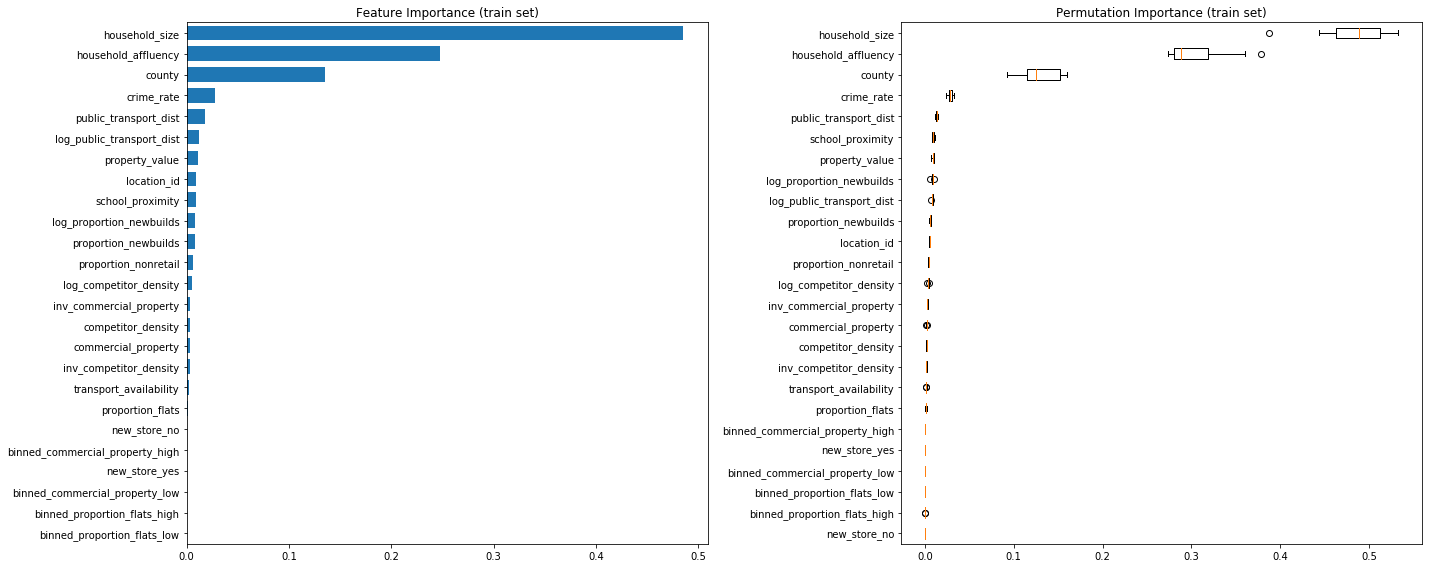

In [28]:
# baseline RF model with default hyperparameter settings using training data without any added features
rf3 = RandomForestRegressor(random_state=seed, oob_score=True)

# fit the model to the training data
rf3.fit(X_train, y_train)

result = permutation_importance(rf3, X_train, y_train, n_repeats=10, random_state=seed)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(rf3.feature_importances_)
tree_indices = np.arange(0, len(rf3.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.barh(tree_indices, rf3.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rf3.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X_train.columns[perm_sorted_idx],
)
ax1.set_title("Feature Importance (train set)")
ax2.set_title("Permutation Importance (train set)")
fig.tight_layout()
plt.show()

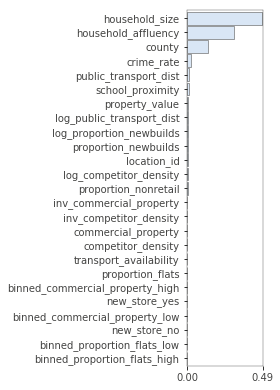

In [29]:
# a cleaner implmentation of permutation importance
imp = importances(rf3, X_train, y_train)
viz = plot_importances(imp)
viz.view()

In [30]:
# keeping only the most important features
X_train2 = X_train[
    [
        "household_size",
        "household_affluency",
        "county",
        "crime_rate",
        "public_transport_dist",
        "property_value",
        "school_proximity",
    ]
]
X_test2 = X_test[
    [
        "household_size",
        "household_affluency",
        "county",
        "crime_rate",
        "public_transport_dist",
        "property_value",
        "school_proximity",
    ]
]

# baseline RF model with default hyperparameter settings using training data
rf4 = RandomForestRegressor(random_state=seed, oob_score=True)

# fit the model to the training data without any added features
rf4.fit(X_train2, y_train)

print("Model evaluation keeping only the most important features:")
fit_and_evaluate_model(rf4, X_train2, X_test2)

# we can achieve the same level of accuracy by only using 7 features

Model evaluation keeping only the most important features:
Number of features used: 7
R-squared Value (train)   :0.98
R-squared Value (test)    :0.85
OOB (Out-Of-Bag) value    :0.83
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.13


## Randomised Search

Grid Search and Randomised Search are 2 different techniques that can be used to tune the model hyperparameters.

In my experience Randomised Search often picks the best result more often than not and in a fraction of the time it takes GridSearchCV.

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


<IPython.core.display.Javascript object>

In [47]:
# baseline RF model with default hyperparameter settings using training data
rf5 = RandomForestRegressor()

# fit the model to the training data without any added features
rf5.fit(X_train2, y_train)

rf_random = RandomizedSearchCV(
    rf5,
    param_distributions=random_grid,
    n_iter=100,
    cv=10,
    verbose=2,
    random_state=seed,
    n_jobs=-1,
)
rf_random.fit(X_train2, y_train)
print("Best parameter (CV score=%0.3f):" % rf_random.best_score_)
print("R-squared Value (test)    :{:.2f}".format(rf_random.score(X_test2, y_test)))
print(
    "Mean Squared Error (test) :{:.2f}".format(
        mean_squared_error(y_test, rf_random.predict(X_test2))
    )
)
print(rf_random.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 16.3min finished


Best parameter (CV score=0.852):
R-squared Value (test)    :0.85
Mean Squared Error (test) :0.13
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': True}


<IPython.core.display.Javascript object>

In [48]:
rf_random.best_estimator_.fit(X_train2, y_train)
# score the model on the train data
print("R-squared Value (train)   :{:.2f}".format(rf_random.score(X_train2, y_train)))
# score the model on the test data
print("R-squared Value (test)    :{:.2f}".format(rf_random.score(X_test2, y_test)))
# Out-Of_Bag score
# print("OOB (Out-Of-Bag) value    :{:.2f}".format(rf_random.oob_score_))

# calculated the mse by comparing predictions against true values
print(
    "Mean Squared Error (train):{:.2f}".format(
        mean_squared_error(y_train, rf_random.predict(X_train2))
    )
)
print(
    "Mean Squared Error (test) :{:.2f}".format(
        mean_squared_error(y_test, rf_random.predict(X_test2))
    )
)

# this model is overfitting

R-squared Value (train)   :0.98
R-squared Value (test)    :0.86
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.13


<IPython.core.display.Javascript object>

In [50]:
# RF model with manuall adjusted hyperparameter settings
rf6 = RandomForestRegressor(random_state=seed, oob_score=True, n_estimators = 1000, max_depth = 10, min_samples_leaf = 1,
                           max_features = 'sqrt', min_samples_split = 2, bootstrap = True)

# fit the model to the training data without any added features
rf6.fit(X_train_orig, y_train)

# hold-out method
def fit_and_evaluate_model(model, train_set, test_set):

    print("Number of features used:", model.n_features_)

    # score the model on the train data
    print("R-squared Value (train)   :{:.2f}".format(model.score(train_set, y_train)))
    # score the model on the test data
    print("R-squared Value (test)    :{:.2f}".format(model.score(test_set, y_test)))
    # Out-Of_Bag score
    print("OOB (Out-Of-Bag) value    :{:.2f}".format(model.oob_score_))

    # calculated the mse by comparing predictions against true values
    print(
        "Mean Squared Error (train):{:.2f}".format(
            mean_squared_error(y_train, model.predict(train_set))
        )
    )
    print(
        "Mean Squared Error (test) :{:.2f}".format(
            mean_squared_error(y_test, model.predict(test_set))
        )
    )


print("Model evaluation without any added features:")
fit_and_evaluate_model(rf6, X_train_orig, X_test_orig)

Model evaluation without any added features:
Number of features used: 16
R-squared Value (train)   :0.98
R-squared Value (test)    :0.86
OOB (Out-Of-Bag) value    :0.86
Mean Squared Error (train):0.02
Mean Squared Error (test) :0.12
